In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

import os

if 'notebook' in os.getcwd():
    os.chdir('..')

import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline


# Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Atari games and others.

In [2]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

d:\Documents\Learning\DSILS\Reinforcement Learning\venv\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


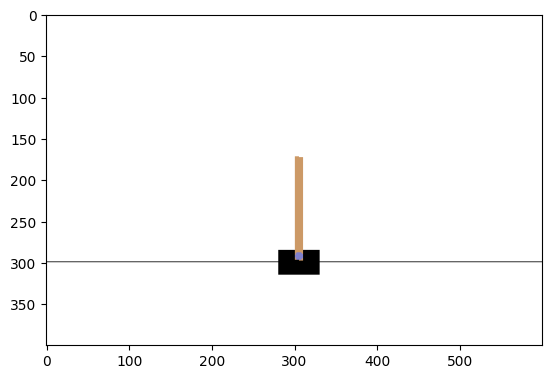

In [3]:
env_name = 'CartPole-v1'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
env.close()
state_shape, n_actions = env.observation_space.shape, env.action_space.n

### Building a network using pytorch

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden layers with Relu activation and final layer being logits with dimension equal to number of actions. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Deep Q-Network

### Description

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update. 

In case of function approximation using neural network, the input to the network is the state and output is the q(s,a) for all the actions in the state `s`. It is denoted as $ \hat{q}(s_t,a; w_{t}) $, where $w_{t}$ is the weigths of the neural network which we are trying to learn as part of DQN learning. 

We use two networks, one target network to get the max q-value of next state denoted by $ \max_a \hat {q}(s_{t+1},a; w^{-}_{t}) $ and the primary network with weights $w_{t}$ which we are updated based on back propagation of the TD error through the network.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a,w^{-}_{t}) – \hat{q}(S_t,A_t,w_t)] \nabla \hat{q}(S_t,A_t,w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values. 

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions (current state, action, reward, next state) in a buffer. Where each sample is denoted as a tuple: 

$$ (s_{i}, a_{i}, r_{i}, s^{'}_{i}, done_{i})$$

Subscript (i) denotes ith sample. We take N samples from experience replay selecting randomly and update the weights. Subscript (t) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


### Model Implementation

In [5]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module('layer1', nn.Linear(state_dim, 192))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('layer2', nn.Linear(192, 256))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('layer3', nn.Linear(256, 64))
        self.network.add_module('relu3', nn.ReLU())
        self.network.add_module('layer4', nn.Linear(64, n_actions))
        # 
        self.parameters = self.network.parameters
        
    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [6]:
dqn_agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [8]:
# Evaluate the inital agent
print(evaluate(env, dqn_agent, n_games=1))
env.close()

12.0


C:\Users\anselmsaungadrian.c\AppData\Local\Temp\ipykernel_68096\1555960691.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.tensor(states, device=device, dtype=torch.float32)


### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [9]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [10]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network


In [11]:
target_network = DQNAgent(dqn_agent.state_shape, dqn_agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(dqn_agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning

Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation: 

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_w L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


$\hat{q}(s',A;w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network. 

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t})$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:

In [12]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values,_ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values" 
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

### Model Training

In [13]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [14]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [15]:
#setup env and agent and target networks
env_name = 'CartPole-v1'
env = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

dqn_agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(dqn_agent.state_dict())

<All keys matched successfully>

In [16]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, dqn_agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [17]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**4

#init Optimizer
opt = torch.optim.Adam(dqn_agent.parameters(), lr=1e-4)

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [18]:
mean_rw_history = []
td_loss_history = []


In [19]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 0.05000


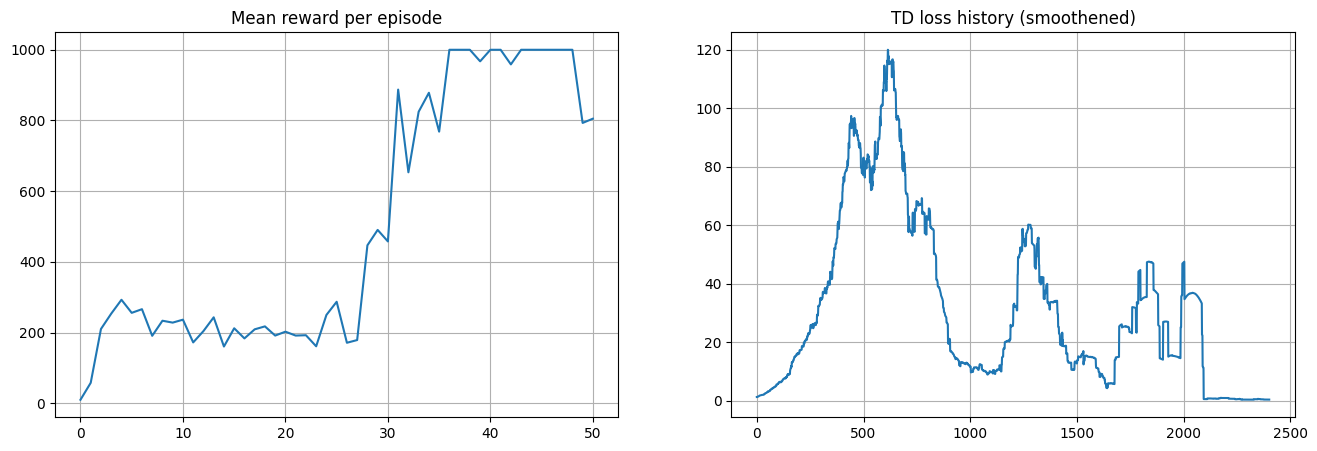

100%|██████████| 50001/50001 [06:29<00:00, 128.45it/s]


In [20]:
state = env.reset()

for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    dqn_agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, dqn_agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    

    # loss = <compute TD loss>
    loss = compute_td_loss(dqn_agent, target_network, 
                           states, actions, rewards, next_states, done_flags,                  
                           gamma=0.99,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(dqn_agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(dqn_agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name, seed=step), dqn_agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), dqn_agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [21]:
final_score = evaluate(
  make_env(env_name),
  dqn_agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 756.6
Well done


**Let us record a video of trained agent**

In [24]:
def generate_animation(env, agent, save_dir):
    
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    reward = 0
    while True:
        qvalues = agent.get_qvalues([state])
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        if done:
            break
    print('Got reward: {}'.format(reward))
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [27]:
# Animate learned policy
save_dir='data/07_model_output/dqn/v0/'
env = make_env(env_name)
generate_animation(env, dqn_agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)


Got reward: 402.0


# Actor Critic

In Actor Critic, we fit the baseline to an estimator for state value V. We use a model as given below:


![Actor Critic](./images/actor_critic.png "Actor Critic")



The final update rule under Actor Critic is given below:

$$\nabla_{\theta,\phi} J\left(\theta,\phi \right)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T}{\nabla_\theta\log{\pi_\theta\left(a_t^i\middle| s_t^i\right)\ }\left[ \hat{Q}(s_t^i,\ a_t^i) -\ V_\phi(s_t^i)\right]\ }$$

In [28]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.actor = nn.Linear(128,n_actions)
        self.critic = nn.Linear(128,1)


    def forward(self, s):
        x = F.relu(self.fc1(s))
        logits = self.actor(x)
        state_value = self.critic(x)
        return logits, state_value
        
a2c_model = ActorCritic(state_shape[0])
a2c_model = a2c_model.to(device)

We will use this function to generate the trajectory. It will not be used for doing back propagation. So we will use PyTorch `no_grad()` to avoid gradient calculations. 

In [29]:
def sample_action(state):
    """
    params: states: [batch, state_dim]
    returns: probs: [batch, n_actions]
    """
    state = torch.tensor(state, device=device, dtype=torch.float32)
    with torch.no_grad():
        logits,_ = a2c_model(state)
    action_probs = nn.functional.softmax(logits, -1).detach().numpy()[0]
    action = np.random.choice(n_actions, p=action_probs)
    return action

In [30]:
def generate_trajectory(env, n_steps=1000, verbose = 0):
    """
    Play a session and genrate a trajectory
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []
    
    # initialize the environment
    s = env.reset()
    
    #generate n_steps of trajectory:
    for t in range(n_steps):
        #sample action based on action_probs
        a = sample_action(np.array([s]))
        next_state, r, done, _ = env.step(a)
        
        #update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = next_state
        if done:
            break
    
    if verbose > 0:
        print('Got reward: {}'.format(sum(rewards)))
    return states, actions, rewards

Calculate Rewards to Go

$G(s_t) = \sum_{t'=t}^{T} \gamma^{t-t'} r(s_{t'}^i, a_{t'}^i)$

In [31]:
def get_rewards_to_go(rewards, gamma=0.99):
    
    T = len(rewards) # total number of individual rewards
    # empty array to return the rewards to go
    rewards_to_go = [0]*T 
    rewards_to_go[T-1] = rewards[T-1]
    
    for i in range(T-2, -1, -1): #go from T-2 to 0
        rewards_to_go[i] = gamma * rewards_to_go[i+1] + rewards[i]
    
    return rewards_to_go

Train on one trajectory

We will calculate the loss and take a gradient step. We will use Adam Optimizer

**policy network loss:**

We are taking only one trajectory. so N=1. We will, however, average it over the number of actions to get the average loss. So the function we will actually implement is as given below:


$$Loss(\theta, \phi) = - J(\theta, \phi) - H(\pi_\theta(a_t|s_t)) = - \frac{1}{T}  \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t|s_t)} \left[ \hat{Q}(s_t,\ a_t) - V_\phi(s_t)\right] \right) - \beta \sum_{a} \pi_\theta(a|s_t).\log{ \pi_\theta(a|s_t)} \right] $$


In [32]:
#init Optimizer
optimizer = torch.optim.Adam(a2c_model.parameters(), lr=1e-3)

def train_one_episode(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    
    # get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)
    

    # get action probabilities from states
    logits, state_values = a2c_model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)
    
    log_probs_for_actions = log_probs[range(len(actions)), actions]
    
    advantage = rewards_to_go - state_values.squeeze(-1)
    
    #Compute loss to be minized
    J = torch.mean(log_probs_for_actions*(advantage))
    H = -(probs*log_probs).sum(-1).mean()
    
    loss = -(J+entropy_coef*H)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return np.sum(rewards) #to show progress on training
    

### Train Model

In [33]:
total_rewards = []
for i in range(10000):
    states, actions, rewards = generate_trajectory(env, verbose = 0)
    reward = train_one_episode(states, actions, rewards)
    total_rewards.append(reward)
    if i != 0 and i % 100 == 0:
        mean_reward = np.mean(total_rewards[-100:-1])
        print("mean reward:%.3f" % (mean_reward))
        if mean_reward > 700:
            break
env.close()


Got reward: 26.0
Got reward: 20.0
Got reward: 24.0
Got reward: 8.0
Got reward: 39.0
Got reward: 28.0
Got reward: 26.0
Got reward: 31.0
Got reward: 19.0
Got reward: 12.0
Got reward: 33.0
Got reward: 22.0
Got reward: 12.0
Got reward: 20.0
Got reward: 22.0
Got reward: 34.0
Got reward: 17.0
Got reward: 34.0
Got reward: 65.0
Got reward: 21.0
Got reward: 19.0
Got reward: 15.0
Got reward: 43.0
Got reward: 15.0
Got reward: 30.0
Got reward: 20.0
Got reward: 22.0
Got reward: 14.0
Got reward: 27.0
Got reward: 15.0
Got reward: 28.0
Got reward: 30.0
Got reward: 43.0
Got reward: 34.0
Got reward: 33.0
Got reward: 35.0
Got reward: 13.0
Got reward: 15.0
Got reward: 16.0
Got reward: 23.0
Got reward: 24.0
Got reward: 15.0
Got reward: 29.0
Got reward: 32.0
Got reward: 39.0
Got reward: 15.0
Got reward: 47.0
Got reward: 16.0
Got reward: 18.0
Got reward: 39.0
Got reward: 27.0
Got reward: 94.0
Got reward: 38.0
Got reward: 35.0
Got reward: 25.0
Got reward: 46.0
Got reward: 35.0
Got reward: 17.0
Got reward: 36.

**Let us record a video of trained agent**

In [34]:
def generate_animation2(env, save_dir):
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    generate_trajectory(env, verbose = 1)

In [35]:
# Animate learned policy
save_dir='data/07_model_output/actor_critic/v0/'
env = make_env(env_name)
generate_animation2(env, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Got reward: 389.0


# Policy Optimization

### Derivation of Policy Gradient

In Policy Optimization, we will have a neural network which takes in state `s` as input and produces the `logits` for action probabilities. 

The policy is parameterized by $\theta$
$$\pi_\theta(a|s)$$

The agent follows the policy and generates the trajectory $\large \tau$ 

$$ s_1 \rightarrow a_1 \rightarrow s_2 \rightarrow a_2 \rightarrow .... \rightarrow s_{T-1} \rightarrow a_{T-1} \rightarrow s_T \rightarrow a_T$$ 

here $s_T$ is not necessarily the terminal state but some time horizon T upto which we are looking at the trajectory. 

The probability of trajectory $\large \tau$ depends on the transition probabilities $p(s_t+1 | s_t, a_t)$ and the policy $\pi_\theta(a_t|s_t)$. It is given by the expression:

$$p_\theta(\tau) = p_\theta(s_1, a_1, s_2, a_2, ..., s_T, a_T) = p(s_1)\prod_{t=1}^{T}\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)$$

The expected return from following the policy $\pi$ is given by:

$$J(\theta) = {\large E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t} \gamma^t r(s_t, a_t) \right]$$

We want to find the $\theta$ which maximizes the expected reward/return $J(\theta)$. In other words, the optimal $\theta=\theta^*$ is given by expression

$$\theta^* = arg \underset{\theta}{max}{\large E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t} \gamma^t r(s_t, a_t) \right] $$

Moving on, let us try to find the optimal $\theta$. To keep the notations easier to understand, we will replace $\sum_{t} \gamma^t r(s_t, a_t)$ as $r(\tau)$:

$$J(\theta) = {\large E}_{\tau \sim p_\theta(\tau)} \left[ r(\tau) \right] = \int p_\theta(\tau)r(\tau) d\tau$$

We take the gradient/derivative of above expression with respect to $\theta$:

$$\nabla_{\theta} J(\theta) =  \nabla_{\theta} \int p_\theta(\tau)r(\tau) d\tau $$

By linearity we can move the gradient inside the integral:

$$\nabla_{\theta} J(\theta) =  \int \nabla_{\theta} p_\theta(\tau)r(\tau) d\tau $$

Using log derivative trick, we know that $\nabla_x f(x) = f(x) \nabla_x \log{f(x)}$. Using this we can write above expression as:

$$\nabla_{\theta} J(\theta) =  \int p_\theta(\tau) \left[ \nabla_{\theta}\log{p_\theta(\tau)} r(\tau) \right] d\tau $$

We can now write the integral back as expectation, which gives us the expression:

$$\nabla_{\theta} J(\theta) =  {\large E}_{\tau \sim p_\theta(\tau)} \left[ \nabla_{\theta}\log{p_\theta(\tau)} r(\tau) \right] $$

Let us now expand the term $\nabla_{\theta}\log{p_\theta(\tau)}$ by writing out the full expression of $p_\theta(\tau)$. 

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \nabla_{\theta} \log{ \left[ p(s_1) \prod_{t=1}^{T}\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)\right]}$$

We know that log of product of terms can be written as sum of log of terms i.e. 

$$\log{\prod_i f_i(x)} = \sum_i log{f_i(x)}$$ 

Using the above substitution, we get:

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \nabla_{\theta} \left[ log{p(s_1)} +  \sum_{t=1}^{T} \left\{ \log{ \pi_\theta(a_t|s_t)} + \log{p(s_{t+1}|s_t,a_t)} \right\} \right]$$

The only term dependent on $\theta$ is $\pi_\theta(a_t|s_t)$. The other two terms $log{p(s_1)}$ and $\log{p(s_{t+1}|s_t,a_t)}$ do not depend on $\theta$. Accordingly, we can simplify the above expression as:

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t|s_t)} $$


Substituting the above term into the expression for $\nabla_{\theta} J(\theta)$, as well as expanding $r(\tau)$ we get:

$$\nabla_{\theta} J(\theta) =  {\large E}_{\tau \sim p_\theta(\tau)} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t|s_t)} \right) \left( \sum_{t=1}^{T} \gamma^t r(s_t, a_t) \right) \right] $$

We can now replace the outer expectation with an estimate over multiple trajectories to get the following expression for the gradient of policy objective:

$$\nabla_{\theta} J(\theta) =  \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t^i|s_t^i)} \right) \left( \sum_{t=1}^{T} \gamma^t r(s_t^i, a_t^i) \right) \right] $$

where i denotes the $i^{th}$ trajectory. 

To improve the policy, we now take a +ve step in $\theta$ in the direction of $\nabla_{\theta} J(\theta)$:

$$\theta = \theta + \alpha \nabla_{\theta} J(\theta)$$

To summarize, we design a model which takes state $s$ as input and produces the policy distribution $\pi_\theta(a|s)$ as the output of the model. We use a policy to generate returns and then change the model parameter $\theta$ using the expression: $\theta = \theta + \alpha \nabla_{\theta} J(\theta)$


#### Rewards to Go Trick


we drop the reward terms that came before time t as at time t, the action we take can only impact the reward which comes at time t and later. This leads to changing the 2nd inner sum going from t’=t to T instead of earlier sum over t’ going from t’=1 to T. i.e. the start index is now t’=t and not t=1. The revised expression is given below:


$$\nabla_{\theta} J(\theta) =  \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) \right] $$


#### Implementing Loss and Gradient Step in PyTorch/TensorFlow

We will implement a pseudo loss function, whose derivative will give us $\nabla_{\theta} J(\theta)$. Also as PyTorch/TensorFlow carryout a gradient Step, we will convert maximization to minimization by changing the sign of this objective function

$$L_{CrossEntropy}(\theta) = - J(\theta) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) \right] $$

To summarize, we will pass the state `s` through the network to get $\log{ \pi_\theta(a_t^i|s_t^i)}$. We will calculate the cross_entropy loss for the actions actually seen in the trajectory. We will then calculate the weighted mean of these individual loss terms in the trajectory with weights being the rewards-to-go $\sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i)$

This will be followed by a gradient step in -ve direction of weighted NLL (negative log loss) i.e. in positive direction of the gradient of $J(\theta)= - L_{CrossEntropy}(\theta)$ 

We also add a regularization term known as Entropy. Entropy of a distribution is defined as:

$$H(X) = \sum_x -p(x).log(p(x))$$

To keep enough exploration, we will want the probability to have a spread out distribution and not let the probability distribution to collapse to a single value or a small region too soon. BIgger the spread of a distribution, higher the entropy H(x) of a distribution. Accordingly, the term fed into PyTorch/TensorFlow minimizer is:


$$Loss(\theta) = - J(\theta) - H(\pi_\theta(a_t^i|s_t^i)) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) - \beta \sum_{a_i} \pi_\theta(a_t^i|s_t^i).\log{ \pi_\theta(a_t^i|s_t^i)} \right] $$



### Build and Train Model

In [39]:
model = nn.Sequential(
            nn.Linear(state_dim[0],192),
            nn.ReLU(),
            nn.Linear(192,n_actions),
)
model = model.to(device)

In [40]:
def predict_probs(states):
    """
    params: states: [batch, state_dim]
    returns: probs: [batch, n_actions]
    """
    states = torch.tensor(states, device=device, dtype=torch.float32)
    with torch.no_grad():
        logits = model(states)
    probs = nn.functional.softmax(logits, -1).detach().numpy()
    return probs

In [41]:
def generate_trajectory2(env, n_steps=1000, verbose = 0):
    """
    Play a session and genrate a trajectory
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []
    
    # initialize the environment
    s = env.reset()
    
    #generate n_steps of trajectory:
    for t in range(n_steps):
        action_probs = predict_probs(np.array([s]))[0]
        #sample action based on action_probs
        a = np.random.choice(n_actions, p=action_probs)
        next_state, r, done, _ = env.step(a)
        
        #update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = next_state
        if done:
            break
    
    if verbose > 0:
        print('Got reward: {}'.format(sum(rewards)))
    return states, actions, rewards

### Train on one trajectory

We will calculate the loss and take a gradient step. We will use Adam Optimizer

We are taking only one trajectory. so N=1. We will however, average it over the number of actions to get the average loss. So the function we will actually implement is as given below:

$$Loss(\theta) = - J(\theta) - H(\pi_\theta(a_t|s_t)) = - \frac{1}{T}  \sum_{t=1}^{T} \left( \log{ \pi_\theta(a_t|s_t)} G(s_t) - \beta \sum_{a_i} \pi_\theta(a_t|s_t).\log{ \pi_\theta(a_t|s_t)} \right) $$

In [42]:
#init Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_episode(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    
    
    # get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)

    # get action probabilities from states
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)
    
    log_probs_for_actions = log_probs[range(len(actions)), actions]
    
    #Compute loss to be minized
    J = torch.mean(log_probs_for_actions*rewards_to_go)
    H = -(probs*log_probs).sum(-1).mean()
    
    loss = -(J+entropy_coef*H)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return np.sum(rewards) #to show progress on training
    

### Train Model

In [43]:
total_rewards = []
for i in range(10000):
    states, actions, rewards = generate_trajectory2(env)
    reward = train_one_episode(states, actions, rewards)
    total_rewards.append(reward)
    if i != 0 and i % 100 == 0:
        mean_reward = np.mean(total_rewards[-100:-1])
        print("mean reward:%.3f" % (mean_reward))
        if mean_reward > 300:
            break
env.close()

mean reward:33.293
mean reward:68.990
mean reward:108.727
mean reward:167.313
mean reward:158.626
mean reward:249.919
mean reward:154.232
mean reward:113.747
mean reward:88.859
mean reward:101.677
mean reward:235.020
mean reward:155.182
mean reward:95.646
mean reward:166.859
mean reward:152.919
mean reward:79.960
mean reward:98.111
mean reward:90.990
mean reward:103.273
mean reward:119.919
mean reward:129.232
mean reward:142.232
mean reward:123.172
mean reward:131.162
mean reward:150.303
mean reward:109.455
mean reward:128.010
mean reward:129.515
mean reward:111.212
mean reward:118.010
mean reward:116.535
mean reward:122.990
mean reward:96.808
mean reward:98.970
mean reward:111.182
mean reward:104.960
mean reward:95.333
mean reward:110.586
mean reward:114.333
mean reward:116.384
mean reward:118.091
mean reward:114.919
mean reward:115.828
mean reward:115.707
mean reward:125.434
mean reward:178.374
mean reward:158.828
mean reward:125.798
mean reward:126.929
mean reward:240.333
mean rewar

**Let us record a video of trained agent**

In [44]:
def generate_animation3(env, save_dir):
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    generate_trajectory2(env, verbose = 1)

In [45]:
# Animate learned policy
save_dir='data/07_model_output/po/v0/'
env = make_env(env_name)
generate_animation3(env, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

# Resources
Source github: **https://github.com/Apress/deep-reinforcement-learning-python**